In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

### Importing dataset

In [2]:
# directly converting the dataset to torch readable, for that we need transform module of torch
import torchvision.transforms as transforms

In [3]:
dataset = MNIST(root='dataset/', 
                train=True,
                transform=transforms.ToTensor())

In [4]:
type(dataset)

torchvision.datasets.mnist.MNIST

Visualizing the data of the dataset

In [5]:
dataset[0]
# we can see every index of dataset is a tuple
# each tuple contains image and label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

Let's visualize a image using matplotlib

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

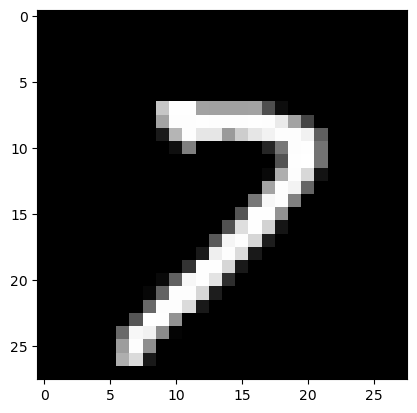

In [7]:
plt.imshow(dataset[567][0][0], cmap="gray")

## Training and Validation Datasets

In [8]:
from torch.utils.data import random_split

In [9]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batch_size = 50
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
model = nn.Linear(784, 10)

In [14]:
model.weight

Parameter containing:
tensor([[-0.0341,  0.0239, -0.0120,  ...,  0.0046,  0.0149,  0.0016],
        [-0.0120, -0.0037,  0.0320,  ..., -0.0192, -0.0065, -0.0170],
        [ 0.0265,  0.0247, -0.0273,  ...,  0.0201,  0.0049, -0.0103],
        ...,
        [ 0.0338, -0.0270, -0.0021,  ..., -0.0203, -0.0312, -0.0247],
        [ 0.0216,  0.0050,  0.0355,  ..., -0.0089,  0.0303, -0.0181],
        [-0.0332, -0.0272,  0.0201,  ...,  0.0227, -0.0107, -0.0206]],
       requires_grad=True)

In [15]:
model.bias

Parameter containing:
tensor([ 0.0214,  0.0273,  0.0218,  0.0344,  0.0212, -0.0184, -0.0019,  0.0038,
         0.0212,  0.0118], requires_grad=True)

In [16]:
# definign the prediction function, which do the linear regression of every batch
def prediction(batch):
    images, _ = batch
    return model(images.reshape(-1, 784))

In [17]:
# to accuracy function we will give two parameter
# para1 -> we will the direct ouput came from model(this is bcz, the output from 
# sofmax function is directly proportional to output of model prediction), prediction, so need of actually calculating softmax seperatly, this will come in use when we will calculate the loss using cross entropy
# para2 -> corresponding original label
def accuracy(prediction, originalLabels):
    _, labelPred = torch.max(prediction, dim=1)
    return torch.sum(labelPred == originalLabels).item()/len(labelPred)

In [18]:
def lossFun(batch):
    _, labels = batch
    pred = prediction(batch)
    loss = F.cross_entropy(pred, labels)
    return loss

In [19]:
"""
we will train the model like -> firstly we will divide the dataset in batches, train the
model on a batch, find out the loss, to decrease the loss set the weights.
For upcoming batch repeate the process
"""

def training_step(learningRate, train_loader):
    optimizer = torch.optim.SGD(model.parameters(), learningRate)
    # this optimizer is used to update the weights and bais
    for batch in train_loader:
        
        # taking out the image and label from every batch
        images, label = batch
        loss = lossFun(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [20]:
# in validation batch step we will calculate the loss and accuracy of a batch of validation dataset
def validation_batch_step(batch):
    images, labels = batch
    pred = prediction(batch)
    loss = lossFun(batch)
    acc = accuracy(pred, labels)
    return {'val_loss': loss, 'val_acc': acc} # keeping the loss and acc in a dictionary and returning ot

In [21]:
# this is an extra step, just to see our training is getting good or not, or we have to change something, or we need to change the model
def validation_step_end(allLossAccOfValLoader):
    batch_losses = [x['val_loss'] for x in allLossAccOfValLoader]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in allLossAccOfValLoader]
    epoch_acc = round(sum(batch_accs)/len(batch_accs), 5)
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc}

In [22]:
def evaluate(val_loader):
    allLossAccOfValLoader = [validation_batch_step(batch) for batch in val_loader]
    return validation_step_end(allLossAccOfValLoader)

In [23]:
def epoch_end(epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [24]:
def fit(epochs, learningRate, train_loader, val_loader):
    
    history = []
    for epoch in range(epochs):
        
        # training phase
        training_step(learningRate, train_loader)
        
        # validation phase
        result = evaluate(val_loader)
        epoch_end(epoch, result)
        history.append(result)
    
    return history

In [25]:
history1 = fit(10, 0.0001, train_loader, val_loader)

Epoch [0], val_loss: 2.2553, val_acc: 0.1787
Epoch [1], val_loss: 2.1557, val_acc: 0.3294
Epoch [2], val_loss: 2.0644, val_acc: 0.4841
Epoch [3], val_loss: 1.9802, val_acc: 0.5874
Epoch [4], val_loss: 1.9021, val_acc: 0.6507
Epoch [5], val_loss: 1.8297, val_acc: 0.6908
Epoch [6], val_loss: 1.7625, val_acc: 0.7142
Epoch [7], val_loss: 1.7001, val_acc: 0.7278
Epoch [8], val_loss: 1.6422, val_acc: 0.7398
Epoch [9], val_loss: 1.5885, val_acc: 0.7511


In [26]:
history2 = fit(10, 0.0001, train_loader, val_loader)

Epoch [0], val_loss: 1.5385, val_acc: 0.7572
Epoch [1], val_loss: 1.4920, val_acc: 0.7648
Epoch [2], val_loss: 1.4487, val_acc: 0.7713
Epoch [3], val_loss: 1.4084, val_acc: 0.7758
Epoch [4], val_loss: 1.3707, val_acc: 0.7797
Epoch [5], val_loss: 1.3356, val_acc: 0.7837
Epoch [6], val_loss: 1.3026, val_acc: 0.7865
Epoch [7], val_loss: 1.2718, val_acc: 0.7906
Epoch [8], val_loss: 1.2429, val_acc: 0.7937
Epoch [9], val_loss: 1.2157, val_acc: 0.7960


In [27]:
history3 = fit(10, 0.0001, train_loader, val_loader)

Epoch [0], val_loss: 1.1901, val_acc: 0.7991
Epoch [1], val_loss: 1.1661, val_acc: 0.8030
Epoch [2], val_loss: 1.1433, val_acc: 0.8048
Epoch [3], val_loss: 1.1219, val_acc: 0.8067
Epoch [4], val_loss: 1.1016, val_acc: 0.8083
Epoch [5], val_loss: 1.0824, val_acc: 0.8100
Epoch [6], val_loss: 1.0641, val_acc: 0.8120
Epoch [7], val_loss: 1.0468, val_acc: 0.8135
Epoch [8], val_loss: 1.0304, val_acc: 0.8153
Epoch [9], val_loss: 1.0147, val_acc: 0.8171


In [28]:
history4 = fit(10, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 0.8916, val_acc: 0.8280
Epoch [1], val_loss: 0.8089, val_acc: 0.8353
Epoch [2], val_loss: 0.7489, val_acc: 0.8417
Epoch [3], val_loss: 0.7036, val_acc: 0.8481
Epoch [4], val_loss: 0.6678, val_acc: 0.8532
Epoch [5], val_loss: 0.6388, val_acc: 0.8552
Epoch [6], val_loss: 0.6147, val_acc: 0.8571
Epoch [7], val_loss: 0.5944, val_acc: 0.8597
Epoch [8], val_loss: 0.5768, val_acc: 0.8628
Epoch [9], val_loss: 0.5617, val_acc: 0.8651


In [29]:
history5 = fit(10, 0.0001, train_loader, val_loader)

Epoch [0], val_loss: 0.5603, val_acc: 0.8651
Epoch [1], val_loss: 0.5589, val_acc: 0.8651
Epoch [2], val_loss: 0.5575, val_acc: 0.8654
Epoch [3], val_loss: 0.5561, val_acc: 0.8655
Epoch [4], val_loss: 0.5548, val_acc: 0.8655
Epoch [5], val_loss: 0.5535, val_acc: 0.8655
Epoch [6], val_loss: 0.5522, val_acc: 0.8655
Epoch [7], val_loss: 0.5509, val_acc: 0.8656
Epoch [8], val_loss: 0.5496, val_acc: 0.8658
Epoch [9], val_loss: 0.5483, val_acc: 0.8661


In [30]:
history6 = fit(10, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 0.5365, val_acc: 0.8673
Epoch [1], val_loss: 0.5258, val_acc: 0.8695
Epoch [2], val_loss: 0.5163, val_acc: 0.8701
Epoch [3], val_loss: 0.5077, val_acc: 0.8711
Epoch [4], val_loss: 0.4997, val_acc: 0.8730
Epoch [5], val_loss: 0.4925, val_acc: 0.8740
Epoch [6], val_loss: 0.4859, val_acc: 0.8752
Epoch [7], val_loss: 0.4797, val_acc: 0.8761
Epoch [8], val_loss: 0.4740, val_acc: 0.8773
Epoch [9], val_loss: 0.4688, val_acc: 0.8784


In [31]:
history7 = fit(10, 0.0001, train_loader, val_loader)

Epoch [0], val_loss: 0.4683, val_acc: 0.8786
Epoch [1], val_loss: 0.4677, val_acc: 0.8786
Epoch [2], val_loss: 0.4672, val_acc: 0.8785
Epoch [3], val_loss: 0.4667, val_acc: 0.8790
Epoch [4], val_loss: 0.4662, val_acc: 0.8791
Epoch [5], val_loss: 0.4657, val_acc: 0.8796
Epoch [6], val_loss: 0.4652, val_acc: 0.8796
Epoch [7], val_loss: 0.4647, val_acc: 0.8795
Epoch [8], val_loss: 0.4642, val_acc: 0.8795
Epoch [9], val_loss: 0.4637, val_acc: 0.8795


In [32]:
history8 = fit(10, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 0.4591, val_acc: 0.8808
Epoch [1], val_loss: 0.4548, val_acc: 0.8811
Epoch [2], val_loss: 0.4506, val_acc: 0.8817
Epoch [3], val_loss: 0.4467, val_acc: 0.8828
Epoch [4], val_loss: 0.4431, val_acc: 0.8830
Epoch [5], val_loss: 0.4395, val_acc: 0.8832
Epoch [6], val_loss: 0.4363, val_acc: 0.8845
Epoch [7], val_loss: 0.4332, val_acc: 0.8852
Epoch [8], val_loss: 0.4302, val_acc: 0.8853
Epoch [9], val_loss: 0.4273, val_acc: 0.8861


In [33]:
history9 = fit(10, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 0.4247, val_acc: 0.8866
Epoch [1], val_loss: 0.4220, val_acc: 0.8872
Epoch [2], val_loss: 0.4196, val_acc: 0.8875
Epoch [3], val_loss: 0.4171, val_acc: 0.8887
Epoch [4], val_loss: 0.4148, val_acc: 0.8889
Epoch [5], val_loss: 0.4126, val_acc: 0.8888
Epoch [6], val_loss: 0.4106, val_acc: 0.8893
Epoch [7], val_loss: 0.4085, val_acc: 0.8902
Epoch [8], val_loss: 0.4066, val_acc: 0.8904
Epoch [9], val_loss: 0.4048, val_acc: 0.8908


In [34]:
history10 = fit(10, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 0.4030, val_acc: 0.8908
Epoch [1], val_loss: 0.4012, val_acc: 0.8911
Epoch [2], val_loss: 0.3994, val_acc: 0.8920
Epoch [3], val_loss: 0.3978, val_acc: 0.8923
Epoch [4], val_loss: 0.3961, val_acc: 0.8928
Epoch [5], val_loss: 0.3947, val_acc: 0.8935
Epoch [6], val_loss: 0.3931, val_acc: 0.8937
Epoch [7], val_loss: 0.3917, val_acc: 0.8939
Epoch [8], val_loss: 0.3903, val_acc: 0.8942
Epoch [9], val_loss: 0.3889, val_acc: 0.8940


In [35]:
history11 = fit(10, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 0.3876, val_acc: 0.8946
Epoch [1], val_loss: 0.3863, val_acc: 0.8951
Epoch [2], val_loss: 0.3850, val_acc: 0.8956
Epoch [3], val_loss: 0.3838, val_acc: 0.8958
Epoch [4], val_loss: 0.3827, val_acc: 0.8958
Epoch [5], val_loss: 0.3815, val_acc: 0.8961
Epoch [6], val_loss: 0.3804, val_acc: 0.8966
Epoch [7], val_loss: 0.3792, val_acc: 0.8967
Epoch [8], val_loss: 0.3782, val_acc: 0.8965
Epoch [9], val_loss: 0.3772, val_acc: 0.8967


In [36]:
history12 = fit(10, 0.001, train_loader, val_loader)

Epoch [0], val_loss: 0.3761, val_acc: 0.8973
Epoch [1], val_loss: 0.3752, val_acc: 0.8969
Epoch [2], val_loss: 0.3742, val_acc: 0.8973
Epoch [3], val_loss: 0.3733, val_acc: 0.8973
Epoch [4], val_loss: 0.3722, val_acc: 0.8970
Epoch [5], val_loss: 0.3714, val_acc: 0.8972
Epoch [6], val_loss: 0.3705, val_acc: 0.8972
Epoch [7], val_loss: 0.3696, val_acc: 0.8972
Epoch [8], val_loss: 0.3688, val_acc: 0.8977
Epoch [9], val_loss: 0.3679, val_acc: 0.8981


In [37]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0341,  0.0239, -0.0120,  ...,  0.0046,  0.0149,  0.0016],
         [-0.0120, -0.0037,  0.0320,  ..., -0.0192, -0.0065, -0.0170],
         [ 0.0265,  0.0247, -0.0273,  ...,  0.0201,  0.0049, -0.0103],
         ...,
         [ 0.0338, -0.0270, -0.0021,  ..., -0.0203, -0.0312, -0.0247],
         [ 0.0216,  0.0050,  0.0355,  ..., -0.0089,  0.0303, -0.0181],
         [-0.0332, -0.0272,  0.0201,  ...,  0.0227, -0.0107, -0.0206]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.1061,  0.2569, -0.0200, -0.0685,  0.0876,  0.3297, -0.0155,  0.2012,
         -0.4569, -0.0657], requires_grad=True)]

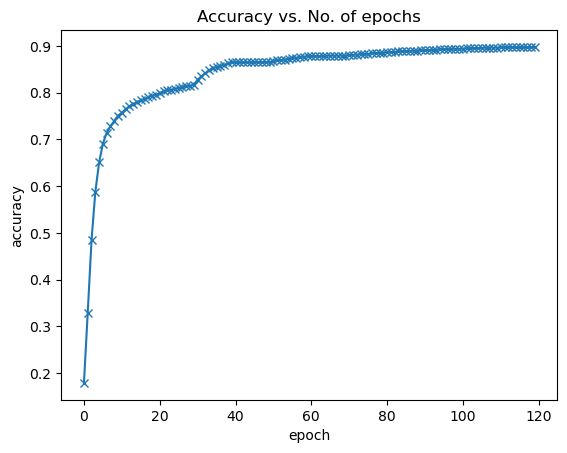

In [38]:
history = history1 + history2 + history3 + history4 + history5 + history6 + history7 + history8 + history9 + history10 + history11 + history12
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Testing with individual image

In [40]:
test_dataset = MNIST(root='dataset/', 
                     train=False,
                     transform=transforms.ToTensor())

In [41]:
test_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [42]:
def predict_image(img, model):
    xb = img.reshape(-1, 784)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    print(preds)

In [44]:
predict_image(test_dataset[98][0], model)

tensor([6])


In [45]:
test_dataset[98][1]

6

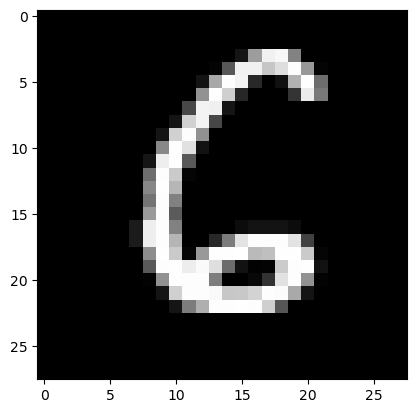

In [90]:
plt.imshow(test_dataset[98][0][0], cmap="gray")

# Saving the model

we will save the models weight and bias, so that in future we no need to train again

In [104]:
torch.save(model.state_dict(), 'SavedModel/T04_MinistModel-linear-logistic.pth')

In [92]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.0341,  0.0239, -0.0120,  ...,  0.0046,  0.0149,  0.0016],
                      [-0.0120, -0.0037,  0.0320,  ..., -0.0192, -0.0065, -0.0170],
                      [ 0.0265,  0.0247, -0.0273,  ...,  0.0201,  0.0049, -0.0103],
                      ...,
                      [ 0.0338, -0.0270, -0.0021,  ..., -0.0203, -0.0312, -0.0247],
                      [ 0.0216,  0.0050,  0.0355,  ..., -0.0089,  0.0303, -0.0181],
                      [-0.0332, -0.0272,  0.0201,  ...,  0.0227, -0.0107, -0.0206]])),
             ('bias',
              tensor([-0.1061,  0.2569, -0.0200, -0.0685,  0.0876,  0.3297, -0.0155,  0.2012,
                      -0.4569, -0.0657]))])

In [105]:
model2 = nn.Linear(784, 10)

In [106]:
model2.load_state_dict(torch.load('SavedModel/T04_MinistModel-linear-logistic.pth'))
model2.state_dict()

OrderedDict([('weight',
              tensor([[-0.0341,  0.0239, -0.0120,  ...,  0.0046,  0.0149,  0.0016],
                      [-0.0120, -0.0037,  0.0320,  ..., -0.0192, -0.0065, -0.0170],
                      [ 0.0265,  0.0247, -0.0273,  ...,  0.0201,  0.0049, -0.0103],
                      ...,
                      [ 0.0338, -0.0270, -0.0021,  ..., -0.0203, -0.0312, -0.0247],
                      [ 0.0216,  0.0050,  0.0355,  ..., -0.0089,  0.0303, -0.0181],
                      [-0.0332, -0.0272,  0.0201,  ...,  0.0227, -0.0107, -0.0206]])),
             ('bias',
              tensor([-0.1061,  0.2569, -0.0200, -0.0685,  0.0876,  0.3297, -0.0155,  0.2012,
                      -0.4569, -0.0657]))])